# Serverless Machine Learning

<hr>

### AWS Lambda

*What is Lambda?*

AWS Lambda is a computing platform which lets you build applications without provisioning or managing servers.

We want to use Lambda to deploy the image classification model we trained previously (Week 8 - Deep Learning).

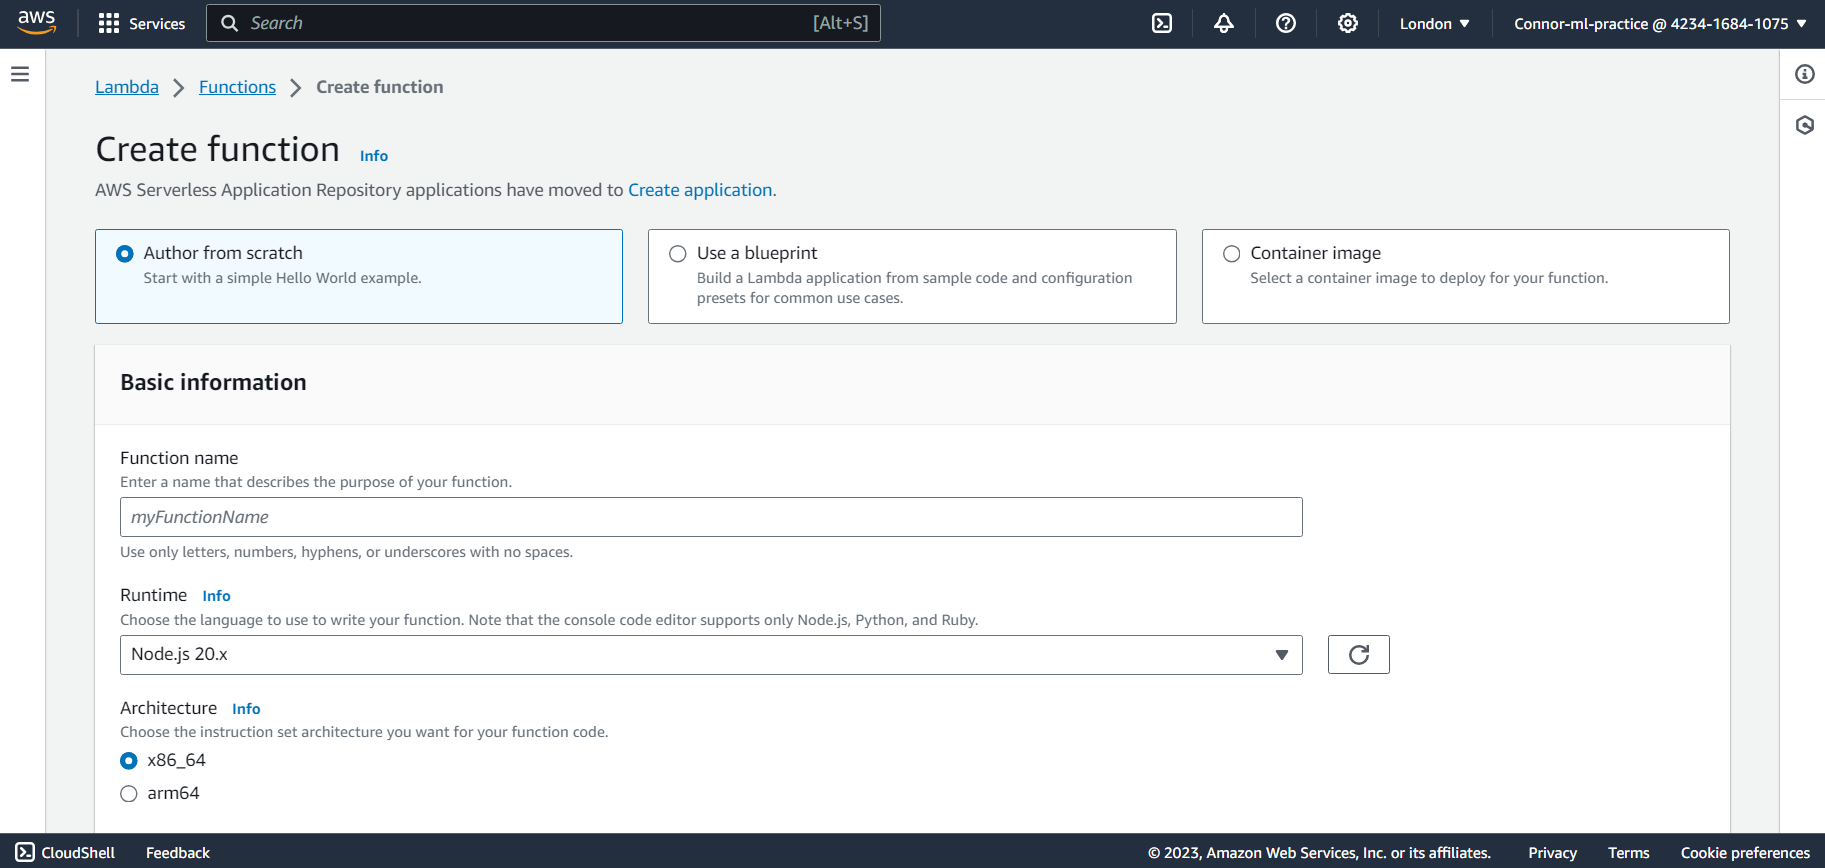

Figure 1: The *Create Function* page for AWS Lambda. Here you can specify basic and advanced information about your function.

For this instance we will call our function `zoomcamp-week-9`, use the `Python 3.11` runtime and leave the architecture as `x86_64` (Windows PC).

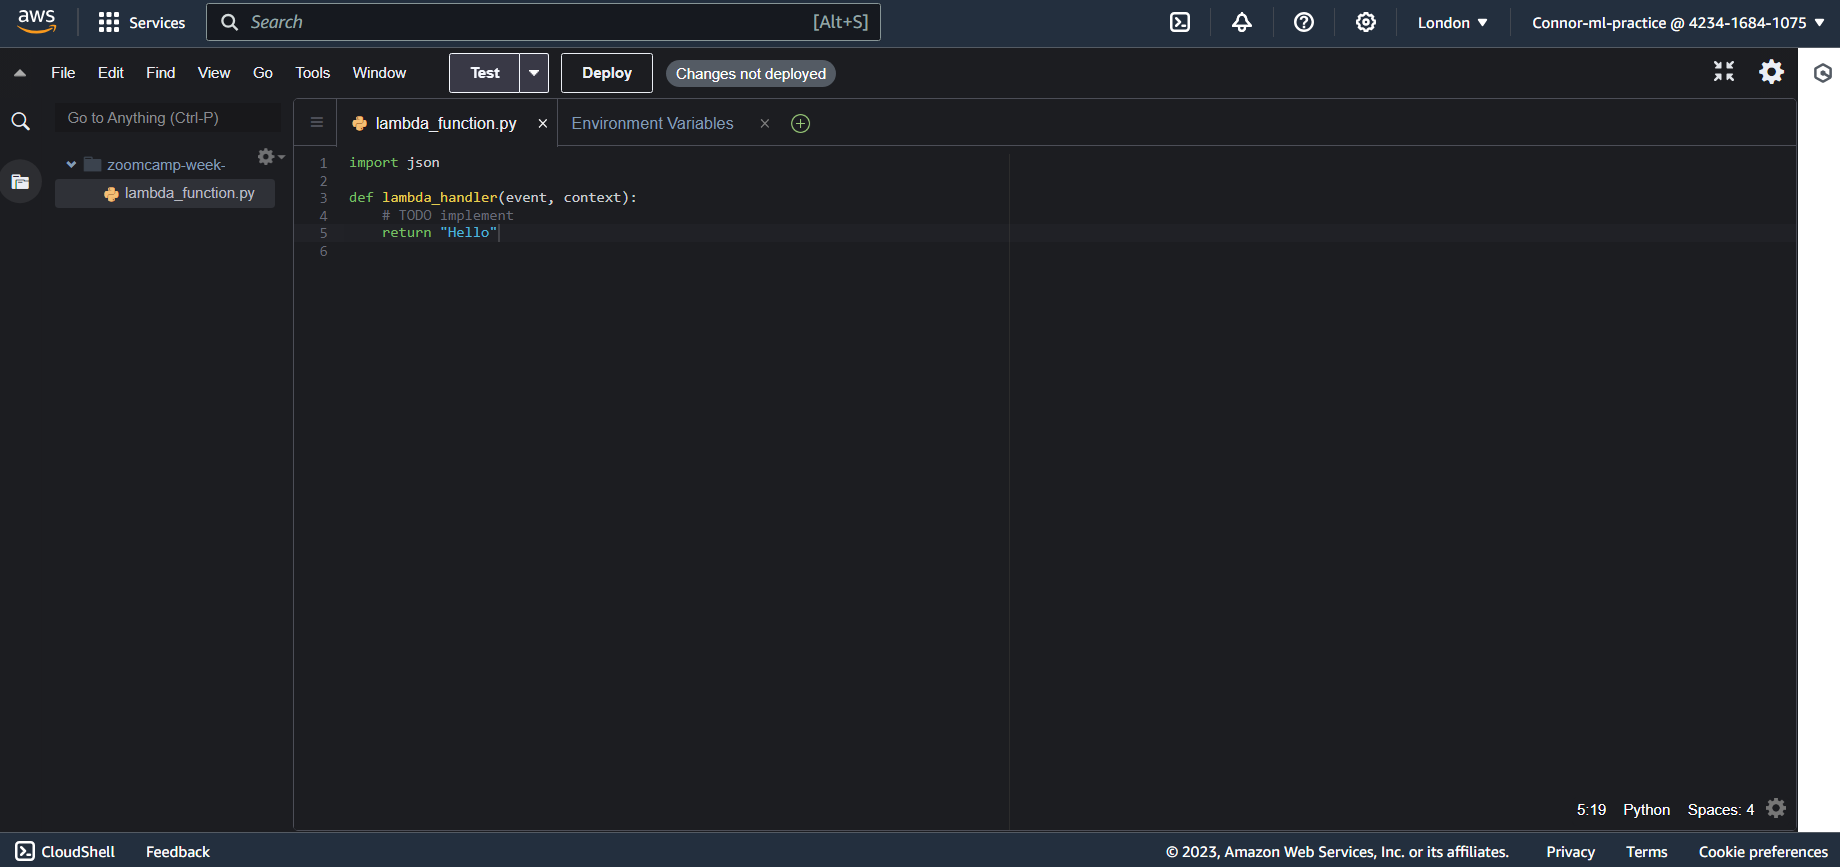

Figure 2: Code interface for Lambda function.

We have one file, `lambda_function.py`, and in this file there is a predefined function called `lambda_handler` which takes an `event` and `context` input. `event` is whatever we want to pass through the function and `context` is usually `None`.

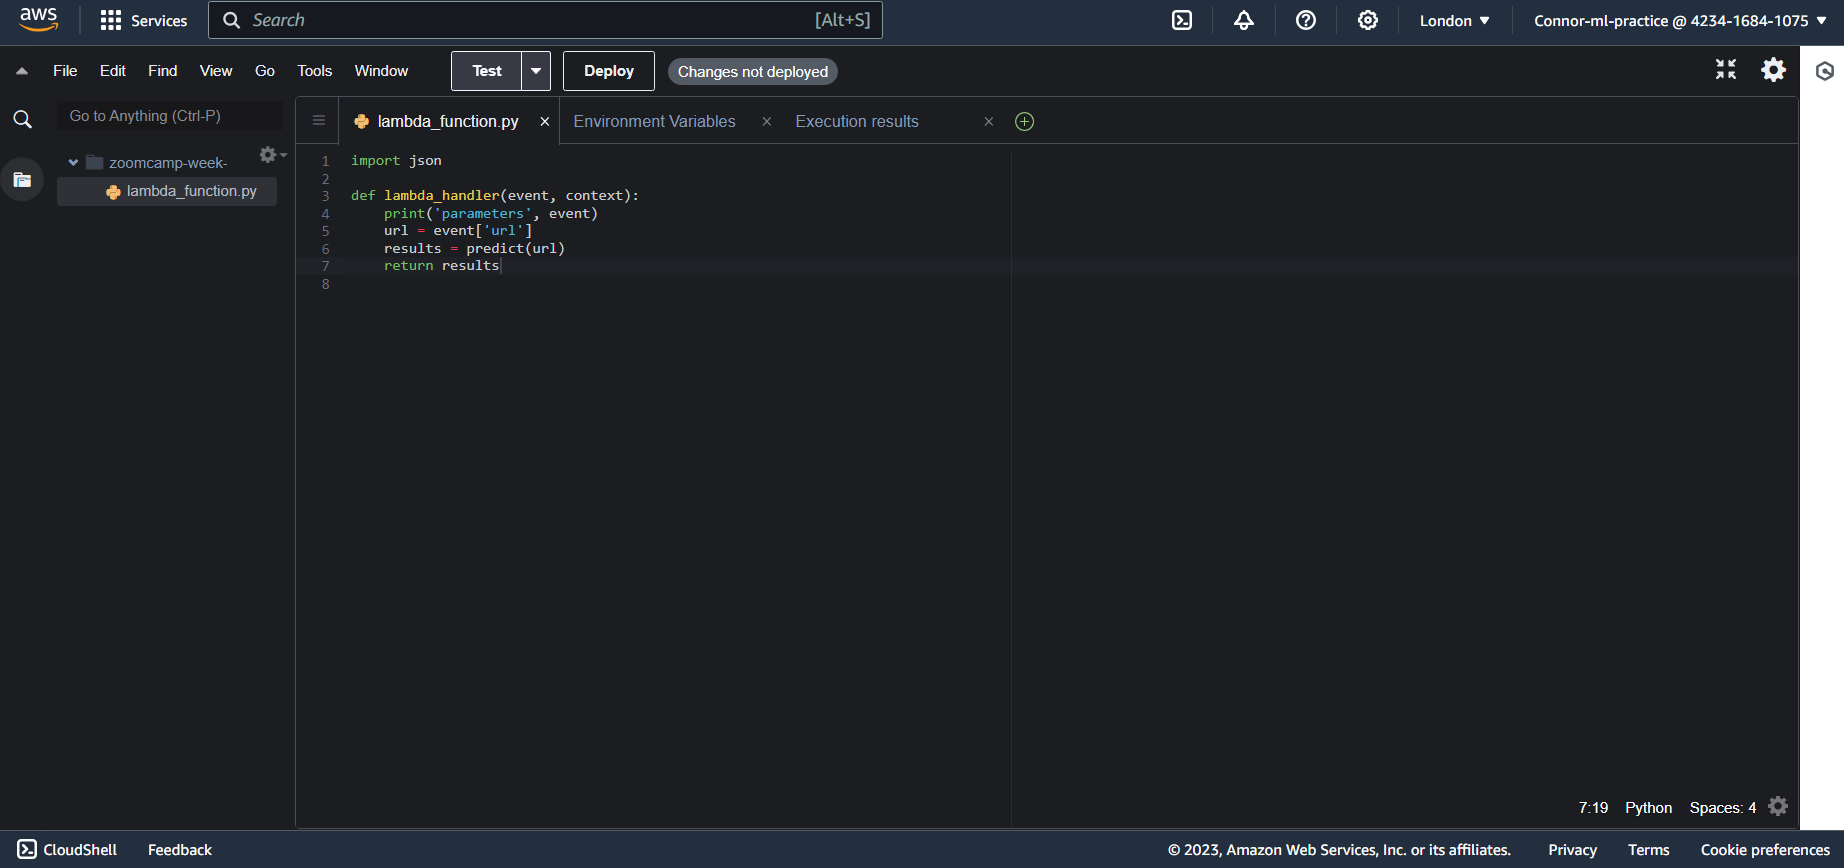

Figure 3: Updated code interface.

Using Lambda we can make calls to our image classification model without worrying about architecture, such as EC2 instances or EB servers. Additionally, Lambda only charges for requests. No requests = No charge. Basically an on-demand function.

TensorFlow is too large for our Lambda instance, so we will discuss `TensorFlow Lite`.

### TensorFlow Lite Introduction

*A lighter version of TensorFlow*

AWS Lambda previously had file size limits. Furthermore, larger images are considerably more expensive.

TensorFlow Lite is only concerned with model inference --> `model.predict()`

### Loading Week 9 Model

In [1]:
import wget

import numpy as np

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import preprocess_input

Downloading the image dataset.

In [2]:
url = 'https://github.com/DataTalksClub/machine-learning-zoomcamp/releases/download/chapter7-model/xception_v4_large_08_0.894.h5'

In [3]:
wget.download(url)

'xception_v4_large_08_0.894 (1).h5'

Loading the pre-trained model.

In [4]:
model = keras.models.load_model('xception_v4_large_08_0.894.h5')

Loading an image for testing.

In [5]:
path = '../Week 8 - Deep Learning/train/pants/0e27351a-13d0-41a6-b731-4090b368d656.jpg'

img = load_img(path, target_size=(299, 299))

Formatting image data for making predictions.

In [6]:
x = np.array(img)
X = np.array([x])

X = preprocess_input(X)

X.shape

(1, 299, 299, 3)

Making predictions.

In [7]:
preds = model.predict(X)

1/1 [==============================] - 2s 2s/step


In [8]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

dict(zip(classes, preds[0]))

{'dress': -2.5024068,
 'hat': -4.461355,
 'longsleeve': -2.6459975,
 'outwear': -0.49210674,
 'pants': 11.107737,
 'shirt': -1.5406778,
 'shoes': -2.3489327,
 'shorts': 0.82085997,
 'skirt': -4.9805193,
 't-shirt': -4.695682}

### Converting Keras to TensorFlow Lite

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('clothing-model.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Tynan\AppData\Local\Temp\tmptvcmsshi\assets


INFO:tensorflow:Assets written to: C:\Users\Tynan\AppData\Local\Temp\tmptvcmsshi\assets


In [10]:
import tensorflow.lite as tflite

Defining an interpreter and the input and output indices.

In [11]:
interpreter = tflite.Interpreter(model_path = 'clothing-model.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

Predictions using the converted TensorFlow Lite model.

In [12]:
interpreter.set_tensor(input_index, X)

interpreter.invoke()

preds = interpreter.get_tensor(output_index)

In [13]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

dict(zip(classes, preds[0]))

{'dress': -2.5024068,
 'hat': -4.4613514,
 'longsleeve': -2.6460094,
 'outwear': -0.49211183,
 'pants': 11.107746,
 'shirt': -1.5406859,
 'shoes': -2.3489246,
 'shorts': 0.82086015,
 'skirt': -4.98052,
 't-shirt': -4.6956816}

Observe that these are the same results as previously.

### Removing TensorFlow Dependency

We do not want to call on TensorFlow when using AWS Lambda and instead want to rely on TensorFlow Lite; however, we are currently utilising both `load_img` and `preprocess_input` from TensorFlow (these functions are not a part of TensorFlow Lite). 

We can work around this by reverse engineering these two functions and identifying alternative methods.

### `load_img` Workaround

In [ ]:
from PIL import Image

In [15]:
with Image.open(path) as img:
    img = img.resize((299, 299), Image.NEAREST)

### `preprocess_image` Workaround

In [16]:
def preprocess_input(x):
    x /= 127.5
    x -= 1.
    return x

<hr>

### Bringing It All Together

Using `tflite_runtime` and `keras_image_helper` to use the model and load the image data, respectively. 

In [23]:
import tflite_runtime as tflite
from keras_image_helper import create_preprocessor

path = '../Week 8 - Deep Learning/train/pants/0e27351a-13d0-41a6-b731-4090b368d656.jpg'

preprocessor = create_preprocessor('xception', target_size=(299, 299))

X = preprocessor.from_path(path)

X.shape

(1, 299, 299, 3)

In [19]:
interpreter = tflite.Interpreter(model_path = 'clothing-model.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [20]:
interpreter.set_tensor(input_index, X)

interpreter.invoke()

preds = interpreter.get_tensor(output_index)

Observe that these are the same results as previously.

In [21]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

dict(zip(classes, preds[0]))

{'dress': -2.5024068,
 'hat': -4.4613514,
 'longsleeve': -2.6460094,
 'outwear': -0.49211183,
 'pants': 11.107746,
 'shirt': -1.5406859,
 'shoes': -2.3489246,
 'shorts': 0.82086015,
 'skirt': -4.98052,
 't-shirt': -4.6956816}

We can now output our TFLite code to a Python script which we will then use for deployment.

### Creating a Lambda Function

Previously, we created a Python script containing the essential code for our TFLite model and also a Docker file which we tested locally. Now, we want to deploy the Docker image to AWS Lambda.

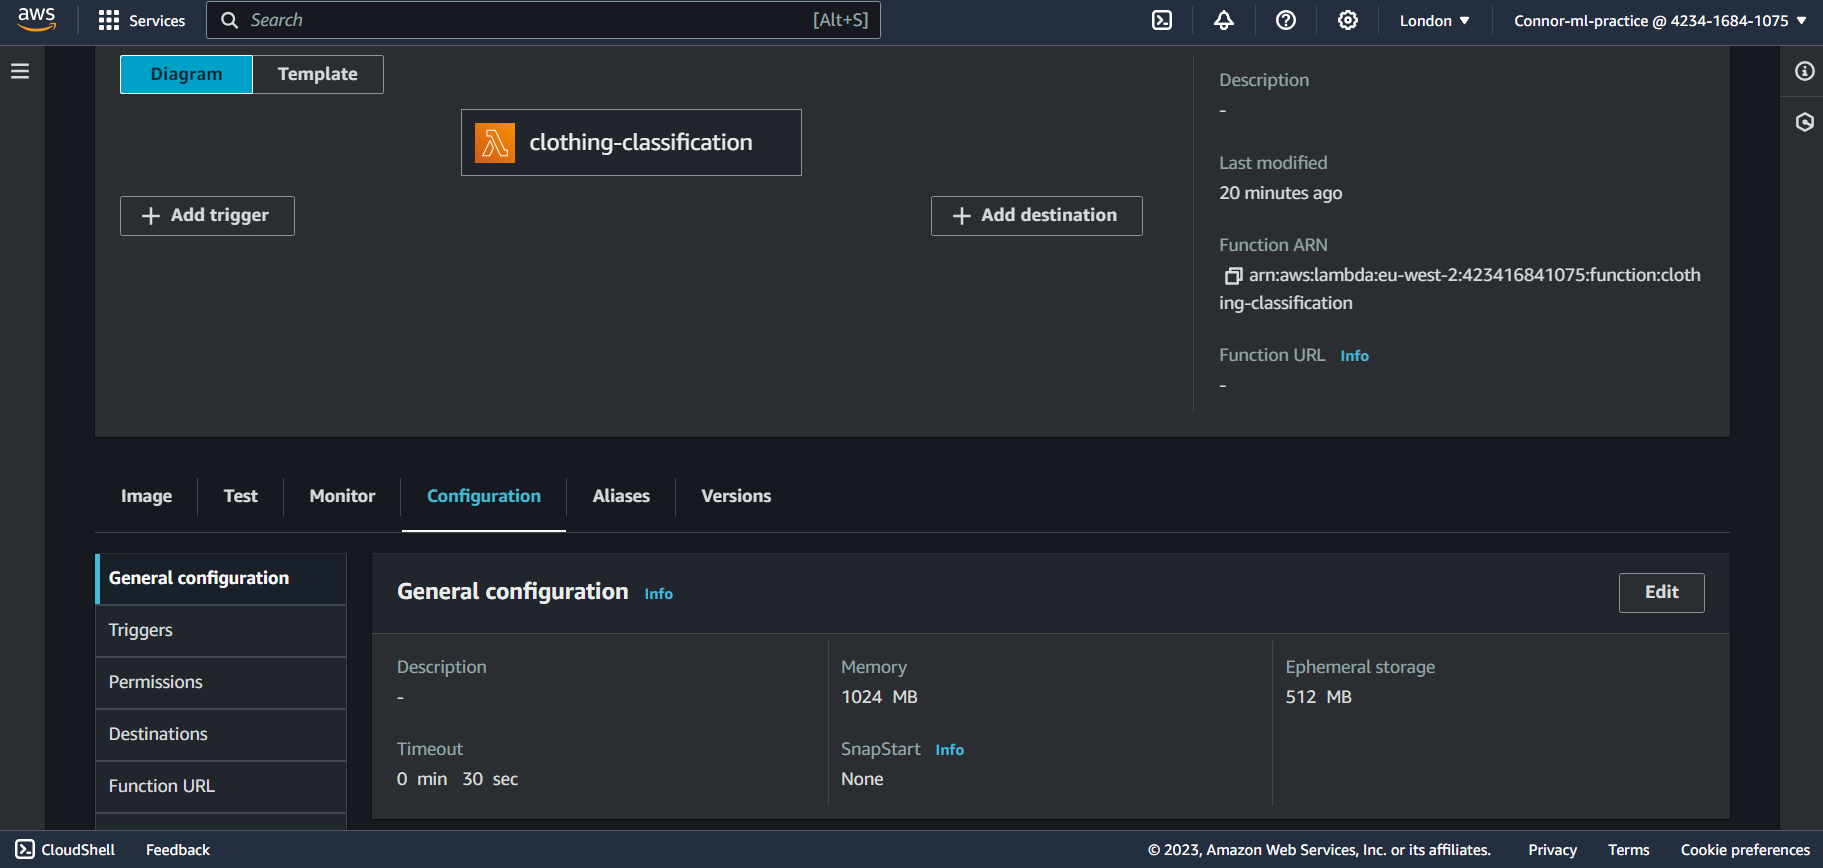

Figure 4: AWS Lambda *from image* interface. The memory was increased from 128 MB to 1024 MB and the timeout limit was increased from 3 seconds to 30 seconds.

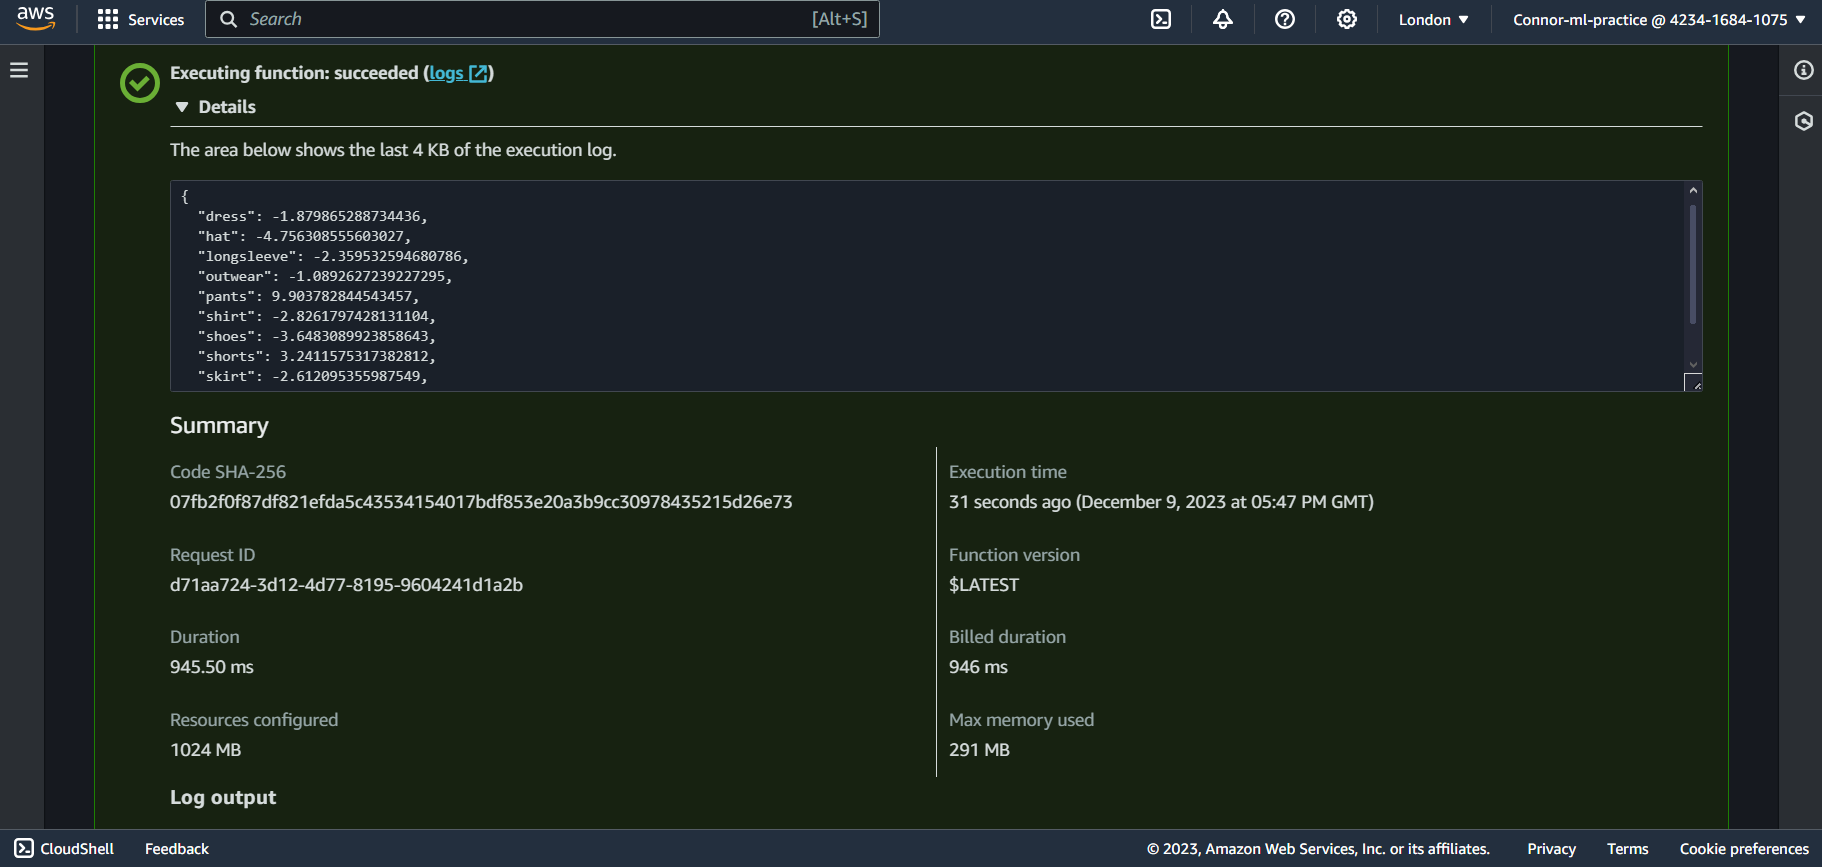

Figure 5: Test case output for our deployed Lambda function. Observe that the output is the same as the local output (which is reassuring).

### API Gateway: Exposing the Lambda Function

AWS API Gateway is a service which allows us to expose multiple AWS services as web services. In our case, we will use a REST API to expose our Lambda function.

**What is an API?**

API stands for *application planning interface* and is a set of rules that determines how applications or devices communicate and interact with each other.

**What is a REST API?**

Simply put, an API that conforms to the principles of REST, an internet protocol that was designed to guide the design and development of the web.

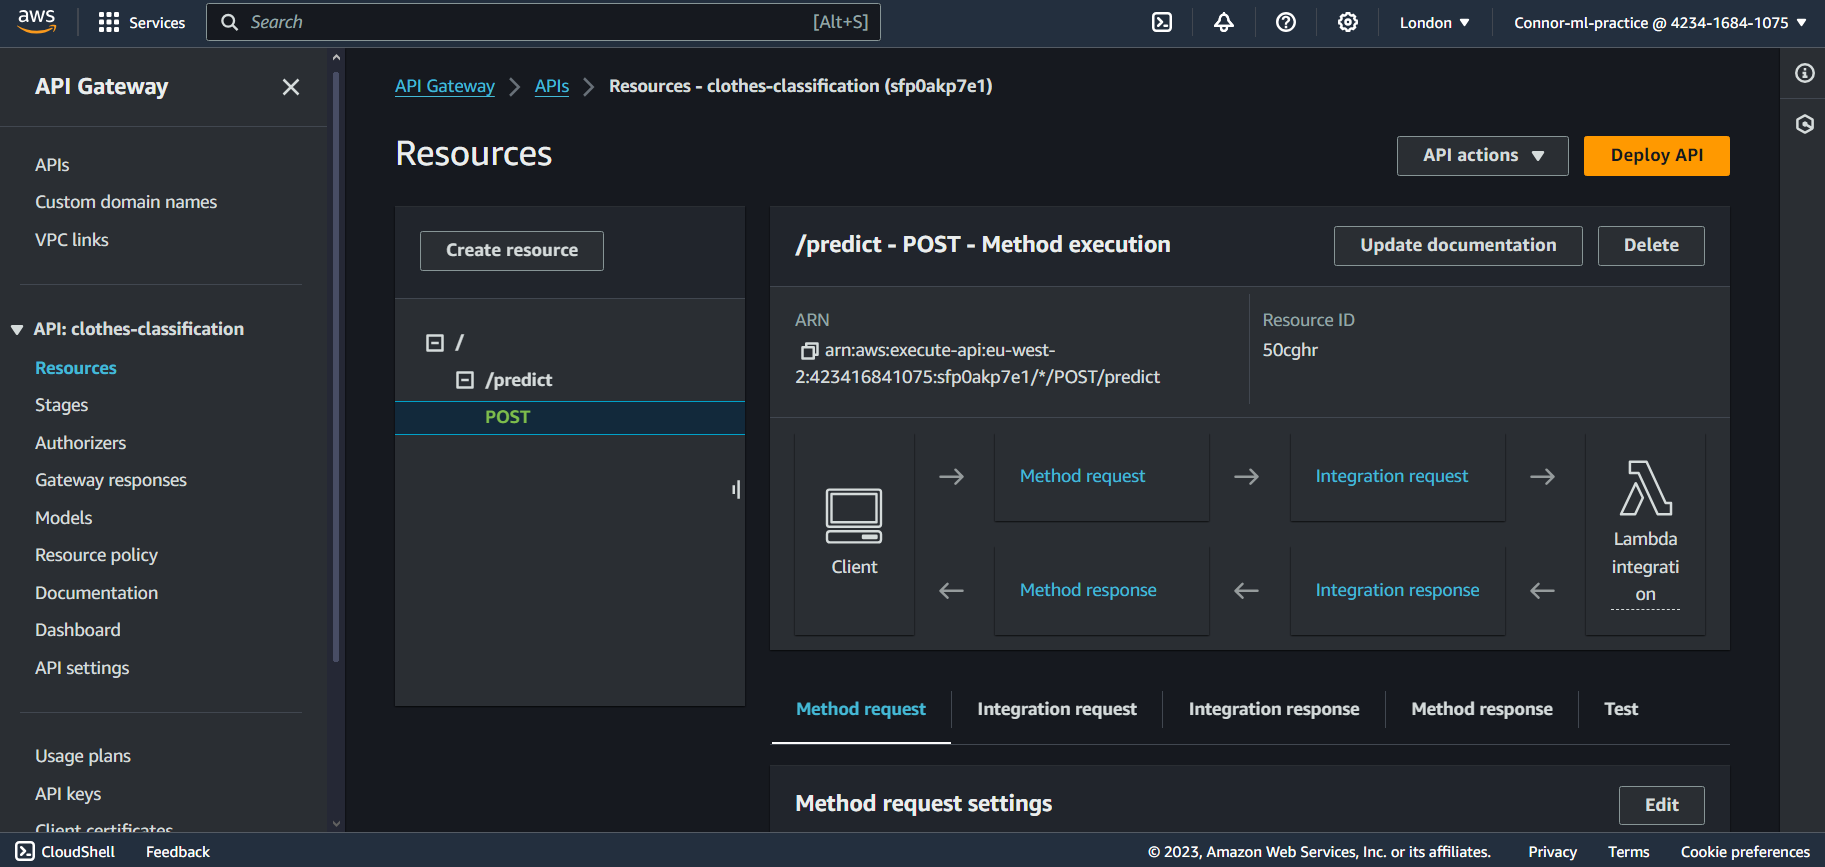

Figure 6: AWS API Gateway interface. For our Lambda function, we want to use the POST method which essentially allows users to make a request to the service which then responds with a set of scores/predictions.

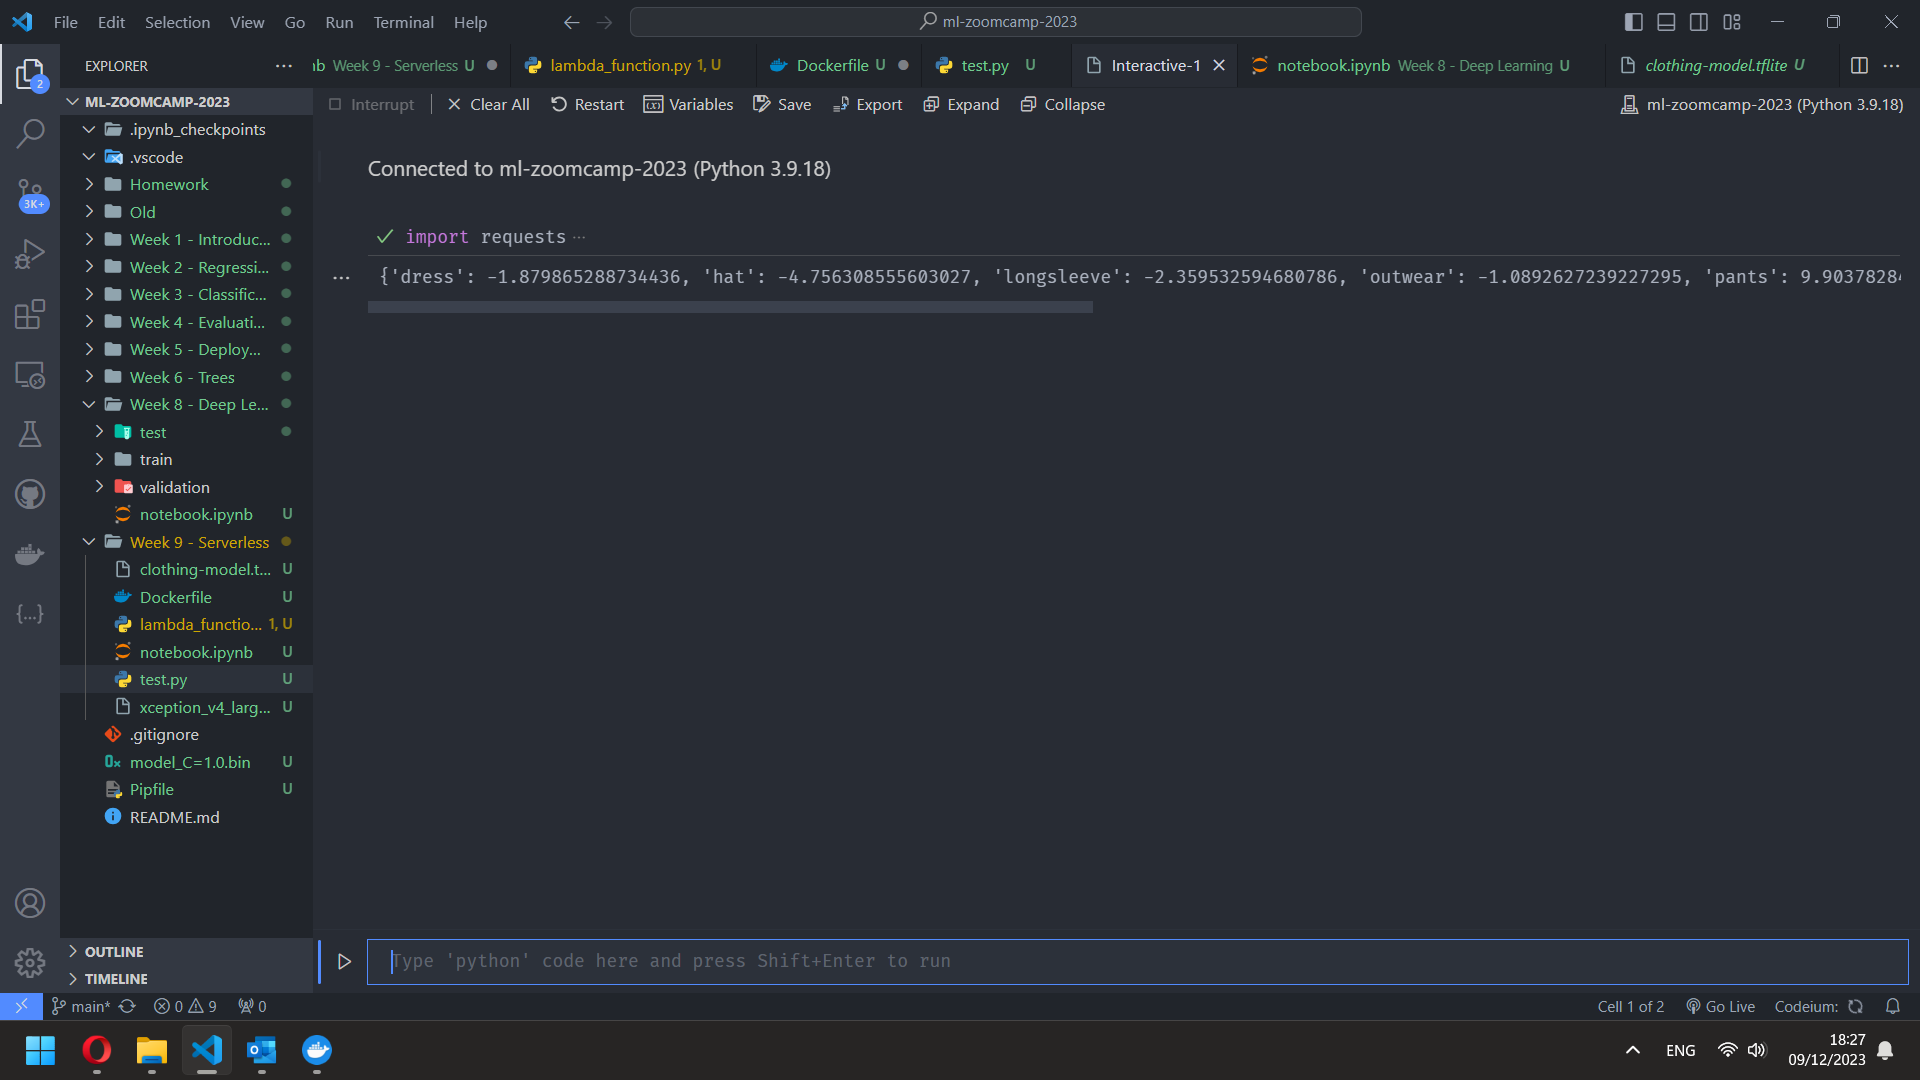

Figure 7: Demonstration of calling the Lamdba function from my local machine using `requests`. See `Week 9 - Serverless/test.py` for more details.

### Summary

- Discussed deploying severless deep learning models using AWS Lambda
- Packaged the code using Docker and tested on local machine
- Pushed the Docker image to ECR
- Initialised a Lambda function from the Docker image, allocating a higher memory and timeout limit for our model to run.
- Exposed the Lambda function using AWS API Gateway and a REST API.